In [1]:
import lib
lib.load_styles_and_macros()

<div class="header">
    <div class="title">
    <h1>Programming Exercise 3</h1>
    </div>
    <div class="authors">
        Prof. Dr. Julia Kowalski<br/>
        Ullika Scholz <br/>
        Ingo Steldermann <br/>
    </div>
    <div class="logo">
        <img src="https://www.mbd.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaabkcpost">
        This content is best viewed in JupyterLab.
    </div>
</div>

# Preliminaries

## Imports

In [5]:
import numpy as np
from scipy.optimize import fminbound, minimize_scalar
from scipy.integrate import quad, dblquad, fixed_quad
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Image
import copy
import time

## Remark:

The complete notebook might take a significant time to execute. On the RWTHjupyter, the reference solutions runs approx. 3 minutes to execute the full notebook.
In case your code needs significantly longer, consider using the RWTHjupyter server.

# Part 1: Finite Volume Method for Different Flux Functions

In [6]:
#start timing
timer_started = time.time()

## Data Class

### Inputs:

The class *Data* contains the information that define our mathematica problem, namely information about:
- the geometry:
    - *a*: position of first node
    - *b*: position of last node
    - *N*: number of nodes (equidistant grid)
- parameters:
    - *cfl*: cfl condition number
- the problem:
    - *eqn_type*: [*advection* | *burgers* ] specify if the advection equation or burgers equation should be solved
    - *flux_type*: [*naiv* | *lax_friedrichs* | *lax_wendroff*] specify which numerial flux function should be used in your solver
    - *init_cond*: [*smooth* | *jump*] specify which initial conditions should be used in your simulation
    
Based on those inputs, the class also computes some derived information, namely:
- *dx*: the grid size
- *u0*: the continuous function definind your initial data, based on *init_cond*.Note: The analytical function is defined in terms of a lambda function, which takes 1 argument (x).
- *u_ex*: the analytical solution for the specified *flux_type* and *init_cond*. Note: The analytical function is defined in terms of a lambda function, which takes 2 arguments (x,t).

### Usage:

You can instantiate this class e.g. by using the following code: \
*>> data = Data(-1, 1, 10, cfl=0.9, init_cond='smooth', eqn_type='advection', flux_type='naiv')*

If you want to access a class variable, (e.g. the gridsize dx), you can then call: \
*>> data.dx*

If you want to evaluate the analytical solution at some point (e.g. x=0.2, t=0.4), you need to call: \
*>> data.u_ex(0.2, 0.4)*

In [7]:
class Data:
    def __init__(self, a, b, N,cfl, init_cond, eqn_type, flux_type):
        self.a=a
        self.b=b
        self.N=N
        self.dx=(b-a)/(N-1)
        self.cfl=cfl
        
        assert(flux_type=='naiv' or flux_type=='lax_friedrichs' or flux_type=='lax_wendroff')
        self.flux_type=flux_type
        
        assert(init_cond=='smooth'or init_cond=='jump' or init_cond=='jump2')
        self.init_cond=init_cond
        
        if (init_cond=='smooth'):
            self.u0 = lambda x: np.sin(2*np.pi*x/(b-a+self.dx))
        elif (init_cond=='jump'):
            self.u0 = lambda x:  1.0 * np.ceil(x+0.5)%2
        elif (init_cond=='jump2'):
            self.u0 = lambda x:  1.0-1.0 * np.ceil(x+0.5)%2
            
        if (eqn_type=='advection'):
            self.eqn_type=eqn_type
            c = 2.
            self.f = lambda u: c*u
            self.df = lambda u: c
            self.u_ex = lambda x,t: self.u0(x) * (x - c*t)# c should be a p.75 script
        elif (eqn_type=='burgers'):
            self.eqn_type=eqn_type
            self.f = lambda u: 0.5*u**2
            self.df = lambda u: u
            if (init_cond=='smooth'):
                self.u_ex= lambda x,t: self.u0(x) * (x - self.u_ex(x,t)*t)
#            elif (init_cond=='jump'):
#                self.u_ex = #TODO
            else:
                assert(False)
        else:
            print('unknown equation type:', eqn_type, ' [advection|burgers]')
            assert(False)

## Numerical Flux Function

F returns the numerical flux function, based on the flux type (*flux_type*) defined in *data*.

In [ ]:
def F(ul, ur, dx, dt, data):
    naivFlux = lambda ul,ur: 0.5 * (data.f(ul) + data.f(ur))
    friedrichsFlux = lambda ul,ur,dx,dt: naivFlux(ul,ur) - dx/(2 * dt) * (ur - ul)
    param = lambda ul,ur: (data.f(ul) + data.f(ur))/(ul - ur)
    wendroffFlux = lambda ul,ur,dx,dt: naivFlux(ul,ur - dt/(2 * dx) np.pow(param(ul,ur),2) * (ur - ul)
    match data:
        case 'naiv':
            returnData = naivFlux
        case 'lax_friedrichs':
            returnData = friedrichsFlux
        case 'lax_wendroff':
            returnData = wendroffFlux
        case _:
            print("wrong input type in F function")

    return returnData

## Useful Functions

<div class="alert alert-danger alert-block">
        The initial condition is specified as a continous function. However, your numerical scheme requires piecewise constant data defined at every cell. Therefore you need to compute the average of the initial condition over each cell.
</div>

**Note:** Be precide about the position of your cell interfaces. Those are located in between two adjacent nodes. The first and last **cell center** was defined at *a* and *b*.\
**Note:**: We assume a **periodic** problem. Luckily, the initial conditions are set up so that you can integrate your initial condition in a domain $x \in [a-dx\, /\, 2, b+dx\,/\,2)$.

In [ ]:
a = np.linspace(1,5,5)
A = np.array([a,a])
print(A)
print(np.roll(A, -1, axis=1))
print(A)
print(np.roll(A, 1, axis=1))

In [ ]:
def compute_u_average(data):
    #TODO

                                                # how should u_average look like?
    return #TODO

The function *compute_dt(data)* should return the time step size *dt* such that the specified cfl condition is met.

In [ ]:
def compute_dt(data):
    #TODO
    return #TODO

The function *compute_next_timestep(U, data)* compures the time step size.\
**Expected input:** current solution *U* at time t $U(t)$ and the data object *data*. \
**Expected return:** new solution at time t+dt: $U(t+dt)$. \
Use **periodic** boundary conditions. A very simple implementation can be achived by using the numpy function *np.roll* (https://numpy.org/doc/stable/reference/generated/numpy.roll.html).

In [ ]:
def compute_next_timestep(U, data):
    #TODO
    return #TODO

This helper function evaluates the analytical solution *data.u_ex* at position *t* for a discrete mesh *X*. \
**Expected input:** current time *t*, data object *data* \
**Expected return:** (mesh_vector, analytical_solution_vector) \
**Note:** both vectors are of equal length

In [ ]:
def get_exact_solution_at(t, data):
    #TODO
    return #TODO

The function *finite_volume_method* executes your FVM simulation for the problem specified in the inputs. It should complete the following tasks: \
-create your data object \
-compute your averaged initial condition \
-advance in time until *tend* is met \
**Expected input:** 
- a, b, N, cfl, init_cond, eqn_type, flux_type --> see Data class 
- *tend*: end time of your simulation 
- *supress_output*: if flag is set *True*, the number of print statements is reduced to a minimum 
**Expected return:** 
- list of solution vectors, one for each time step (include initial condition) 
- list of times, where the solutions are computed 
- data object

In [ ]:
def finite_volume_method(a, b, N, tend, cfl, init_cond, eqn_type, flux_type, suppress_output=False):
    #TODO
    return U_list, T_list, data

# Simulations

## Plot Solution

Let's try out our code on different test cases:

In [ ]:
fig, ax = plt.subplots(4,3)

U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='naiv')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[0,0].plot(X, U_list[-1])
ax[0,0].plot(X_ex, U_ex)
ax[0,0].set_title('smooth -- adv. -- naiv')

U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='lax_friedrichs')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[0,1].plot(X, U_list[-1])
ax[0,1].plot(X, U_list[-1])
ax[0,1].set_title('smooth -- adv. -- LF')
                  
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='lax_wendroff')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[0,2].plot(X, U_list[-1])
ax[0,2].plot(X_ex, U_ex)
ax[0,2].set_title('smooth -- adv. -- LW')                  
                  
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='naiv')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[1,0].plot(X, U_list[-1])
ax[1,0].plot(X_ex, U_ex)
ax[1,0].set_title('jump -- adv. -- naiv')                  
                  
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='lax_friedrichs')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[1,1].plot(X, U_list[-1])
ax[1,1].plot(X_ex, U_ex)
ax[1,1].set_title('jump -- adv. -- LF')                  
                  
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='lax_wendroff')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[1,2].plot(X, U_list[-1])
ax[1,2].plot(X_ex, U_ex)
ax[1,2].set_title('jump -- adv. -- LW')                  
                  
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='naiv')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[2,0].plot(X, U_list[-1])
ax[2,0].plot(X_ex, U_ex)
ax[2,0].set_title('smooth -- burgers -- naiv')                  
                  
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='lax_friedrichs')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[2,1].plot(X, U_list[-1])
ax[2,1].plot(X_ex, U_ex)
ax[2,1].set_title('smooth -- burgers -- LF')                  
                  
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='lax_wendroff')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[2,2].plot(X, U_list[-1])
ax[2,2].plot(X_ex, U_ex)
ax[2,2].set_title('smooth -- burgers -- LW')                  
                  
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='naiv')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[3,0].plot(X, U_list[-1])
ax[3,0].plot(X_ex, U_ex)
ax[3,0].set_title('jump -- burgers -- naiv')                  
                  
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='lax_friedrichs')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[3,1].plot(X, U_list[-1])
ax[3,1].plot(X_ex, U_ex)
ax[3,1].set_title('jump -- burgers -- LF')                  
                  
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='lax_wendroff')
X = np.linspace(data.a, data.b, data.N)
X_ex, U_ex = get_exact_solution_at(T_list[-1], data)
ax[3,2].plot(X, U_list[-1])
ax[3,2].plot(X_ex, U_ex)
ax[3,2].set_title('jump -- burgers -- LW')

fig.set_figwidth(20)
fig.set_figheight(8)
fig.tight_layout()
plt.show()

### Compare to reference solution code

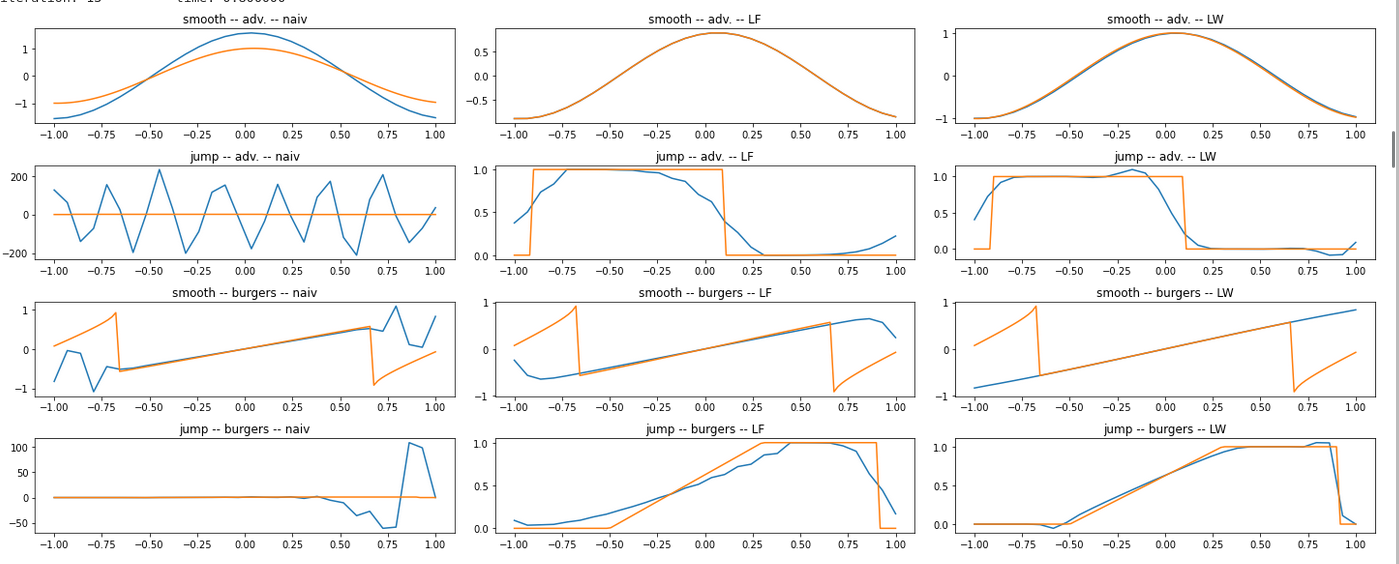

## Animate Solution

The following code will plot the numerical and analytical solution obtained above. 

In [ ]:
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='naiv')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='lax_friedrichs')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='lax_wendroff')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='naiv')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='lax_friedrichs')
# U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='advection', flux_type='lax_wendroff')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='naiv')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='lax_friedrichs')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='smooth',  eqn_type='burgers', flux_type='lax_wendroff')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='naiv')
#U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='lax_friedrichs')
# U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=0.8, cfl=0.9, init_cond='jump',  eqn_type='burgers', flux_type='lax_wendroff')

In [ ]:
%%capture
fig, ax = plt.subplots()
X_ex, U_ex = get_exact_solution_at(0.0, data)
X = np.linspace(data.a, data.b, data.N)
U_plot, = ax.plot(X, U_list[0])
U_plot_ex, = ax.plot(X_ex, U_ex)

def animate(i):
    X_ex, U_ex = get_exact_solution_at(T_list[i], data)
    ax.set_title('IC: ' + data.init_cond + '   eqn_type:' + data.eqn_type + '   method: ' + data.flux_type + '   time: ' + str(np.round(T_list[i], 3)))
    U_plot.set_ydata(U_list[i]) 
    ax.set_ylim(np.min(U_list[0])-0.1, np.max(U_list[0])+0.1)
    U_plot_ex.set_ydata(U_ex)
    U_plot.set_drawstyle('steps-mid')
    U_plot.set_marker('.')
    return U_plot,
anim = animation.FuncAnimation(
    fig, animate, frames=len(U_list), interval=80, blit=True)

In [ ]:
HTML(anim.to_jshtml())

# Part 2: Convergence Analysis

## Useful Functions

<div class="alert alert-danger alert-block">
        We need to numerically evaluate the integral over one space-time element from $[x_{i-1/2}, x_{i+1/2}]\times[t_i, t_{i+1}]$.
</div>
As a recommandation, you may use the function *fixed_quad(lambda x: f(x), x0, x1, n=5* (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.fixed_quad.html), which is a fifth order numerical integration scheme for a one dimensional function. 
In order to obtain a two dimensional integration over our space time element, you need to integrate slices (in time or space) of your space time element. The position of those slices correspond to the 'outer' 1D quadrature.
In case you do not want to use the *fixed_quad* function for your outer (or inner) quadrature, you can also implement it yourself. See (https://en.wikipedia.org/wiki/Gaussian_quadrature) for a quick reference. 

**Expected input:** 
- du: Integrand of the L1 norm. Note: define du as a function with arguments (x,t)
- t0,t1,x0,x1: borders of the space-time-cell
**Expected return:** L1-error of space-time cell

In [ ]:
def dblquad_5th_order(du, t0, t1, x0, x1):
    #TODO
    return #TODO
    


To make things easier, let's split our L1_error function into two parts. The function *L1_error* should return the error for the solution under consideration. The function *L1_error_timestep* takes our numerical solution for one space-time cell $[x_0, x_1]\times[t_0, t_1]$ and computes its L1-error. 
The flag *projected* indicates if the analytical solution should be projected onto its cell-wise constant approximation.

<div class="alert alert-danger alert-block">
        The projection operator $P_0 u$ should compute $\int_{x_{k}}^{x_{k+1}} u_{ex}(t_k,x) \, dx \, / \,(x_{k+1}-x_k)$. So we compute the mean in space and use the time step $t_k$ for the time interval $[t_0,t_1]$.
</div>

In [ ]:
def L1_error_timestep(U, x0, x1, t0, t1, data, projected=False):
    #TODO
    return #TODO

In [ ]:
def L1_error(U_list, T_list, data, projected=False):
    #TODO
    return #TODO

### Testing

In [ ]:
U_list, T_list, data = finite_volume_method(a=-1, b=1, N=30, tend=1.0, cfl=0.9, init_cond='smooth',  eqn_type='advection', flux_type='lax_wendroff')
print('L1-error', L1_error(U_list, T_list, data))
print('L1-error projected', L1_error(U_list, T_list, data, projected=True))

### Verify your results

The output of the reference solution reads:
```
iteration: 10 	 time: 0.310345
iteration: 20 	 time: 0.620690
iteration: 30 	 time: 0.931034
iteration: 33 	 time: 1.000000
L1-error 0.1399267727178231
L1-error projected 0.00535844265424244

```


## Plotting Tools

This function generates your convergence plots. \
**Expected inputs:** 
- *meshsizes*: list of the different meshsizes under consideration, e.g. [20, 40, 80, 160, 320]
- *l_errors*: list of L1-errors. Must have the same size as *meshsizes*
- *l_errors_proj*: list of projected L1-errors. Must have the same size as *meshsizes*
- *l_data*: list of data objects. Must have the same size as *meshsizes*


In [ ]:
def convergence_plots(meshsizes, l_errors, l_errors_proj, l_data):
    fig, ax = plt.subplots(1,len(l_errors))
    def generate_plot_from_axis(ax, meshsizes, errors, errors_projected, data):
        def minmax(l):
            l_min = min(l)
            l_max = max(l)
            return [l_min, l_max]
        meshsizes = np.array(meshsizes)
        ax.loglog(meshsizes, errors, 'xg')
        ax.loglog(meshsizes, errors_projected, 'xb')
        ax.loglog(minmax(meshsizes), errors[0]*min(meshsizes**0.5)/minmax(meshsizes**0.5), '--g', alpha=0.5, label="0.5 order")
        ax.loglog(minmax(meshsizes), errors[0]*min(meshsizes)/minmax(meshsizes), '-g', alpha=0.5, label="1 order ")
        ax.loglog(minmax(meshsizes), errors[0]*min(meshsizes**2)/minmax(meshsizes**2), '--g', alpha=0.5, label="2 order")
        ax.loglog(minmax(meshsizes), errors_projected[0]*min(meshsizes**0.5)/minmax(meshsizes**0.5), '--b', alpha=0.5, label="0.5 order (projected)")
        ax.loglog(minmax(meshsizes), errors_projected[0]*min(meshsizes)/minmax(meshsizes), '-b', alpha=0.5, label="1 order (projected)")
        ax.loglog(minmax(meshsizes), errors_projected[0]*min(meshsizes**2)/minmax(meshsizes**2), '--b', alpha=0.5, label="2 order (projected)")
        ax.set_xlabel('number of nodes')
        ax.set_ylabel('L1 error')
        ax.set_title('L1-error with \n IC: ' + data.init_cond + '\n eqn_type:' + data.eqn_type + '\n method: ' + data.flux_type, loc='left')
        ax.legend()
        ax.axis('equal')
    fig.set_figwidth(20)
    fig.set_figheight(8)
    #plt.tight_layout()
    if len(l_errors)==1:
        generate_plot_from_axis(ax, meshsizes, l_errors, l_errors_proj, l_data)
    else:
        for i in range(len(l_errors)):
            generate_plot_from_axis(ax[i], meshsizes, l_errors[i], l_errors_proj[i], l_data[i])

## Error Analysis

### Compute error for advection equation with smooth initial conditions

In [ ]:
N_samples=4
meshsizes = [20* 2**(i) for i in range(N_samples)]
dh = [2**4 / 2**(i) for i in range(N_samples)]
l_errors=[]
l_errors_proj=[]
l_data=[]

#naiv
#TODO
    
#lax_friedrichs
#TODO
    
#lax_wendroff
#TODO

In [ ]:
convergence_plots(meshsizes, l_errors, l_errors_proj, l_data)

### Verify your results 

The plots of the reference solution code. The computation was run with $(cfl=0.9, tend=0.3)$ using smooth initial condition and the advection flux:

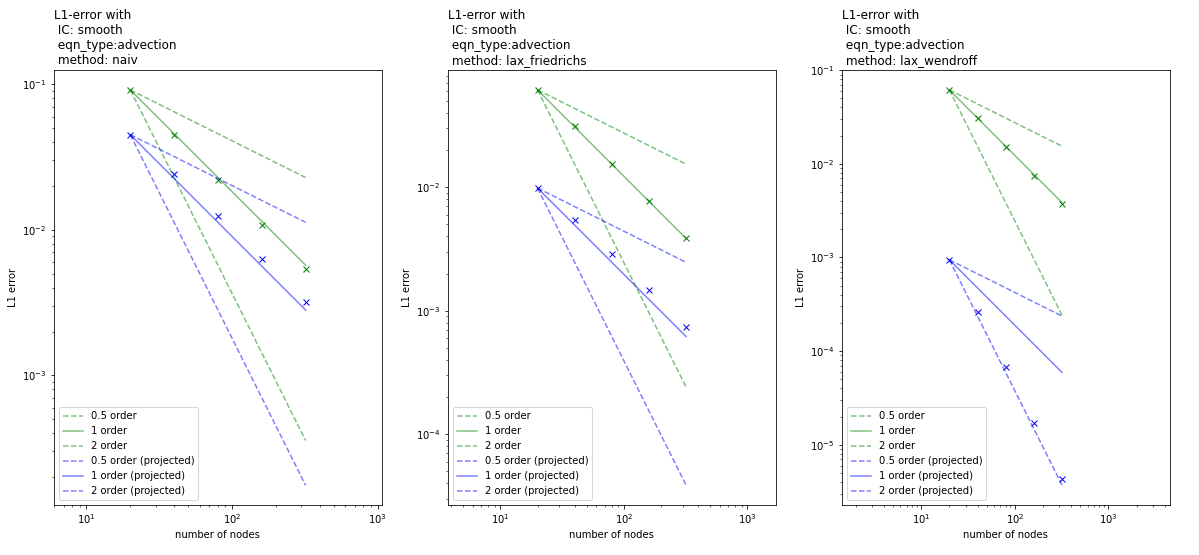

In [ ]:
### Compute error for advection equation with jump initial conditions

In [ ]:
N_samples=4
meshsizes = [20* 2**(i) for i in range(N_samples)]
dh = [2**4 / 2**(i) for i in range(N_samples)]
l_errors=[]
l_errors_proj=[]
l_data=[]

#naiv
#TODO
    
#lax_friedrichs
#TODO
    
#lax_wendroff
#TODO

In [ ]:
convergence_plots(meshsizes, l_errors, l_errors_proj, l_data)

### Compute error for Burgers equation with smooth initial conditions 

In [ ]:
N_samples=4
meshsizes = [20* 2**(i) for i in range(N_samples)]
dh = [2**4 / 2**(i) for i in range(N_samples)]
l_errors=[]
l_errors_proj=[]
l_data=[]

#naiv
#TODO
    
#lax_friedrichs
#TODO
    
#lax_wendroff
#TODO

In [ ]:
convergence_plots(meshsizes, l_errors, l_errors_proj, l_data)

### Compute error for Burgers equation with jump initial conditions 

In [ ]:
N_samples=4
meshsizes = [20* 2**(i) for i in range(N_samples)]
dh = [2**4 / 2**(i) for i in range(N_samples)]
l_errors=[]
l_errors_proj=[]
l_data=[]

#naiv
#TODO
    
#lax_friedrichs
#TODO
    
#lax_wendroff
#TODO

In [ ]:
convergence_plots(meshsizes, l_errors, l_errors_proj, l_data)

In [ ]:
#end timeing
time.time()-timer_started